# Description:

    Investigate Core microbiome of different groups of samples
    Note: log2fold change file was run on full sequencing set, without the sparsity filter, need to rerun differential abundance notebook with new filter



# Setting variables

In [15]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTUexploration/'
biomFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/'

biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt'
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'

log2foldFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/bare-plant.csv'


# Init

In [16]:
import os
from pandas import DataFrame
from IPython.display import FileLink

In [17]:
%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [18]:
%%R
library(vegan)
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)

# Explore DeSeq output to define core microbiomes

### Read DeSeq output

In [19]:
%%R -i log2foldFile
l2f = read.csv(log2foldFile, header = TRUE)
colnames(l2f)

 [1] "log2FoldChange" "p"              "Rank1"          "Rank2"         
 [5] "Rank3"          "Rank4"          "Rank5"          "Rank6"         
 [9] "Rank7"          "Rank8"          "OTU"            "Day"           
[13] "Plant"          "p.adj"         


In [20]:
%%R
l2f.sig = l2f[l2f$p.adj < .05,]
dim(l2f.sig)

[1] 8597   14


### Spread by plant to make matrix of log2fold change in each OTU by plant combo

In [21]:
%%R
df = l2f.sig[,c(1,11,13)]
l2f_m = spread(df, Plant, log2FoldChange, fill = 0, drop = TRUE)
l2f_m %>% head

        OTU   75-062    ABUTH    AMAPO      B73      B97    ECHCG    ELCOR
1    OTU.10 3.755553 3.554574 3.913238 4.730054 3.983959 4.116643 3.242262
2   OTU.100 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
3  OTU.1000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
4 OTU.10009 0.000000 0.000000 4.848621 5.219825 0.000000 0.000000 6.751878
5  OTU.1001 0.000000 0.000000 0.000000 6.053131 6.493816 0.000000 0.000000
6 OTU.10030 0.000000 0.000000 2.353137 0.000000 0.000000 0.000000 0.000000
     ERATE    FAGES    GLYMA      H99    HELAN    Hp301    Il14H      Ki3
1 3.998816 2.226031 4.493125 2.409564 2.879535 4.408774 4.349912 4.357638
2 0.000000 1.042526 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
3 0.000000 1.939025 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
4 5.927989 0.000000 4.524680 0.000000 0.000000 0.000000 0.000000 0.000000
5 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
6 0.000000 4.359155 0.000000 0.

In [22]:
%%R
dim(l2f_m) %>% print

matrix.please<-function(x) {
    m<-as.matrix(x[,-1])
    rownames(m)<-x[,1]
    m
}
l2f_mat = matrix.please(l2f_m)
head(l2f_mat)

[1] 1506   23
            75-062    ABUTH    AMAPO      B73      B97    ECHCG    ELCOR
OTU.10    3.755553 3.554574 3.913238 4.730054 3.983959 4.116643 3.242262
OTU.100   0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.1000  0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.10009 0.000000 0.000000 4.848621 5.219825 0.000000 0.000000 6.751878
OTU.1001  0.000000 0.000000 0.000000 6.053131 6.493816 0.000000 0.000000
OTU.10030 0.000000 0.000000 2.353137 0.000000 0.000000 0.000000 0.000000
             ERATE    FAGES    GLYMA      H99    HELAN    Hp301    Il14H
OTU.10    3.998816 2.226031 4.493125 2.409564 2.879535 4.408774 4.349912
OTU.100   0.000000 1.042526 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.1000  0.000000 1.939025 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.10009 5.927989 0.000000 4.524680 0.000000 0.000000 0.000000 0.000000
OTU.1001  0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.10030 0.000000 4.359155 0.000000 

## Ordinate significant log two-fold change

In [23]:
%%R
bc = vegdist(t(l2f_mat), method="bray", binary=TRUE)


In [26]:
%%R
l2f.sig$Day

 [1] "log2FoldChange" "p"              "Rank1"          "Rank2"         
 [5] "Rank3"          "Rank4"          "Rank5"          "Rank6"         
 [9] "Rank7"          "Rank8"          "OTU"            "Day"           
[13] "Plant"          "p.adj"         


In [11]:
%%R
ord <- metaMDS(bc)

Run 0 stress 0.1240072 
Run 1 stress 0.1240075 
... procrustes: rmse 0.0001089707  max resid 0.0003964623 
*** Solution reached


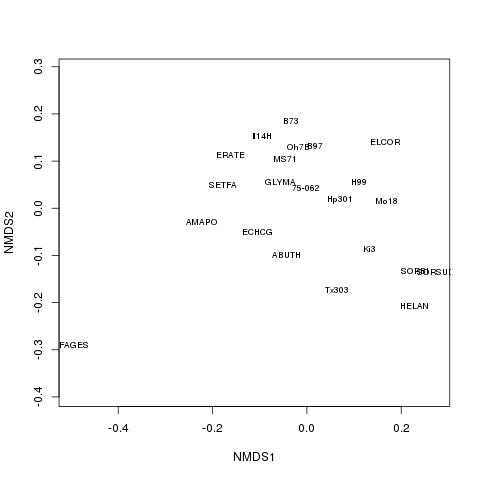

In [12]:
%%R
plot(ord, type = "t")

In [31]:
%%R
pdf(file = "/home/bryan/RhizCG/figures/l2fCluster.pdf")
CL <- hclust(bc, method="average")
CL
plot(CL, main = "Cluster Dendrogram of l2f \n Bray-Curtis Distances")
dev.off()

png 
  2 


$type
[1] "phylogram"

$use.edge.length
[1] TRUE

$node.pos
[1] 1

$node.depth
[1] 1

$show.tip.label
[1] TRUE

$show.node.label
[1] FALSE

$font
[1] 3

$cex
[1] 1

$adj
[1] 0

$srt
[1] 0

$no.margin
[1] FALSE

$label.offset
[1] 0

$x.lim
[1] 0.0000000 0.4229338

$y.lim
[1]  1 22

$direction
[1] "rightwards"

$tip.color
numeric(0)

$Ntip
[1] 22

$Nnode
[1] 21

$root.time
NULL



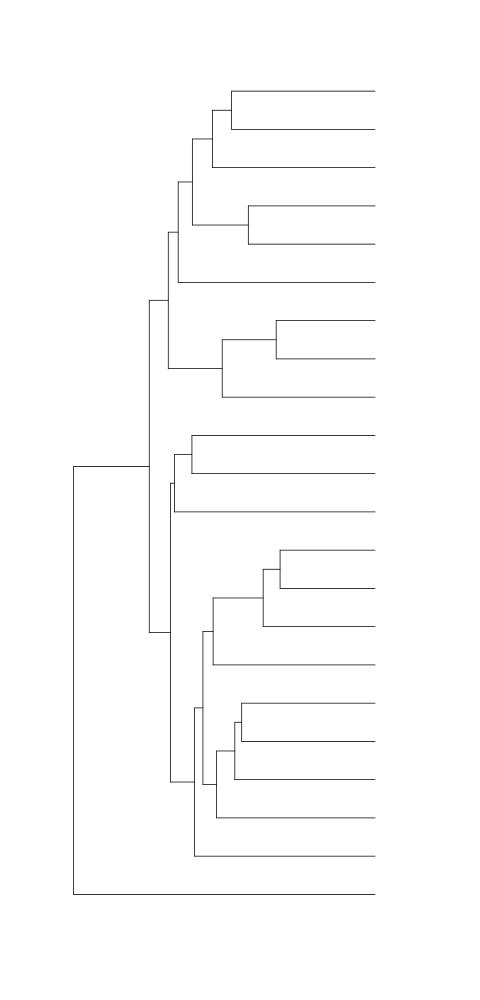

In [29]:
%%R -h 1000
library(ape)
Var = l2f.sig$Day  %>% levels # factor variable for colors
result_phylo <- as.phylo(CL)
p = plot(result_phylo, tip.col = as.numeric(as.character(Var)))
p

## Define l2f cores by group

### Core rhizosphere (all plants)

In [56]:
%%R


rc_sel = apply(l2f_mat, 1,function (x) min(x) > 0)
   
l2f_rhizcore = l2f_mat[rc_sel,]    
dim(l2f_rhizcore)    

[1] 29 22


Rhizosphere Core: 29 OTUs significantly enriched in all rhizospheres

### Maize

In [55]:
%%R
colnames(l2f_mat)

 [1] "75-062" "ABUTH"  "AMAPO"  "B73"    "B97"    "ECHCG"  "ELCOR"  "ERATE" 
 [9] "FAGES"  "GLYMA"  "H99"    "HELAN"  "Hp301"  "Il14H"  "Ki3"    "Mo18"  
[17] "MS71"   "Oh7B"   "SETFA"  "SORBI"  "SORSUD" "Tx303" 


In [60]:
%%R
maize_mat = l2f_mat[,c("75-062", "B73", "B97", "H99","Hp301",  "Il14H",  "Ki3", "Mo18", "MS71", 
                       "Oh7B", "Tx303")] 

c_sel = apply(maize_mat, 1,function (x) min(x) > 0)
   
l2f_maizecore = maize_mat[c_sel,]    
dim(l2f_maizecore)                   

[1] 106  11


Maize Core Rhizosphere: 106 OTUs consistently enriched

## C4 grasses not including maize

In [63]:
%%R
C4.nm_mat = l2f_mat[,c("ECHCG",  "ELCOR",  "ERATE", "SETFA",  "SORBI",  "SORSUD")] 

c_sel = apply(C4.nm_mat, 1,function (x) min(x) > 0)
   
l2f_C4.nmcore = C4.nm_mat[c_sel,]    
dim(l2f_C4.nmcore)   

[1] 63  6


### C4 grasses including maize

In [65]:
%%R
C4_mat = l2f_mat[,c("75-062", "B73", "B97", "H99","Hp301",  "Il14H",  "Ki3", "Mo18", "MS71", 
                       "Oh7B", "Tx303", "ECHCG",  "ELCOR",  "ERATE", "SETFA",  "SORBI",  "SORSUD")] 

c_sel = apply(C4_mat, 1,function (x) min(x) > 0)
   
l2f_C4core = C4_mat[c_sel,]    
dim(l2f_C4core)   

[1] 48 17


In [ ]:
Dicots